### Pipeline do projeto de TC4

Implementando o LSTM utilizando o valor de 'Close', se não satifatorio será utilizado a variação do preço em % para treinamento do LSTM


#### Importando as bibliotecas

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import joblib

Criando as funções de gráfico

In [2]:
def plot_closing_price_time_series(data, symbol):
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Preço de Fechamento Original')
    plt.title(f'Série Temporal do Preço de Fechamento de {symbol} (Original)')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_normalized_closing_price_time_series(data, symbol):
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Preço de Fechamento Normalizado')
    plt.title(f'Série Temporal do Preço de Fechamento de {symbol} (Normalizado)')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento (Escalado)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_training_and_test_data(train_data, test_data, symbol):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['Close'], label='Dados de Treino (Normalizados)')
    plt.plot(test_data['Close'], label='Dados de Teste (Normalizados)')
    plt.title(f'Dados de Treino e Teste de {symbol} (Normalizados)')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento (Escalado)')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Coletando os dados historicos da Microsoft Ticker 'MSFT'

Utilizando um intervalo de 5 anos.

Utilizando o preço de 'Close' para analise qual será o melhor para o LSTM.

In [3]:
symbol = 'MSFT'
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

In [4]:
period = '5y'

In [69]:
df = yf.download(symbol, period=period ,multi_level_index=False)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [6]:
df = df[['Close']]
df.index = pd.to_datetime(df.index)

In [7]:
df.head()

,Close
Date,


#### Caso falhe o yfinance usando o Alpha Vantage para donwload.

In [ ]:
from alpha_vantage.timeseries import TimeSeries
from dotenv import load_dotenv
import os

api_key = os.getenv('ALPHA_KEY')

ts = TimeSeries(key=api_key, output_format='pandas')
df, meta_data = ts.get_daily(symbol=symbol, outputsize="full")



In [9]:
meta_data

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'MSFT',
 '3. Last Refreshed': '2025-02-18',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

In [10]:
df = df[['4. close']]
df = df.rename(columns={'4. close': 'Close'})
df.index = pd.to_datetime(df.index)

In [11]:
start_date = pd.to_datetime('2020-01-02')
end_date = pd.to_datetime('today')

# Verificar se a start_date está no índice e, se não, pegar a primeira data disponível após ela
if start_date not in df.index:
    start_date = df.index[df.index >= start_date][0]

# Filtrar o DataFrame entre start_date e end_date
df = df.loc[(df.index >= start_date) & (df.index <= end_date)]

In [12]:
df = df.sort_index(ascending=True)
df.head()

,Close
date,
2020-01-02,160.62
2020-01-03,158.62
2020-01-06,159.03
2020-01-07,157.58
2020-01-08,160.09


#### Visualizando dos Dados Brutos

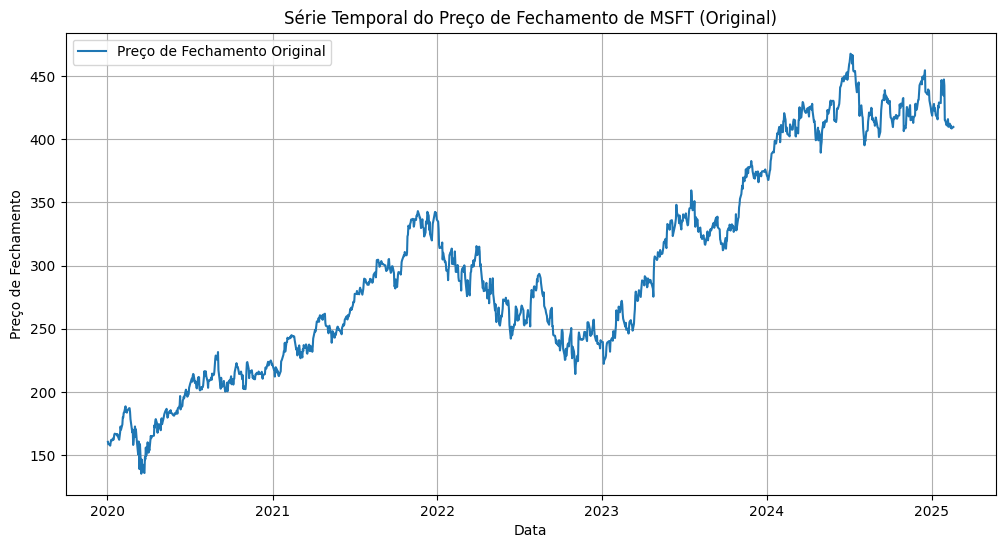

In [13]:
plot_closing_price_time_series(df, symbol)

#### Pré-processamento

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

In [16]:
joblib.dump(scaler, 'Scaler_model.pkl')

['Scaler_model.pkl']

In [17]:
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

In [18]:
df_scaled.head()

,Close
date,
2020-01-02,0.075872
2020-01-03,0.069850
2020-01-06,0.071084
2020-01-07,0.066719
2020-01-08,0.074276


#### Visualizando dos Dados Normalizados

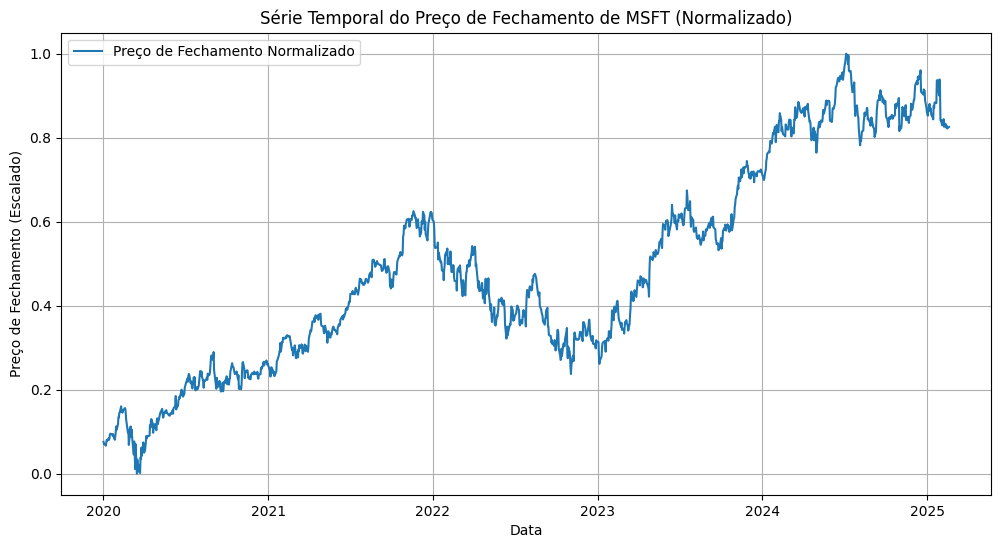

In [19]:
plot_normalized_closing_price_time_series(df_scaled, symbol)

#### Data Splitting (Treino e Teste)

In [20]:
train_size = int(len(df) * 0.8)
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

In [21]:
print(f"Tamanho dos dados de treino: {len(train_data)}")
print(f"Tamanho dos dados de teste: {len(test_data)}")

Tamanho dos dados de treino: 1031
Tamanho dos dados de teste: 258


#### Visualizando os Dados de Treino e Teste

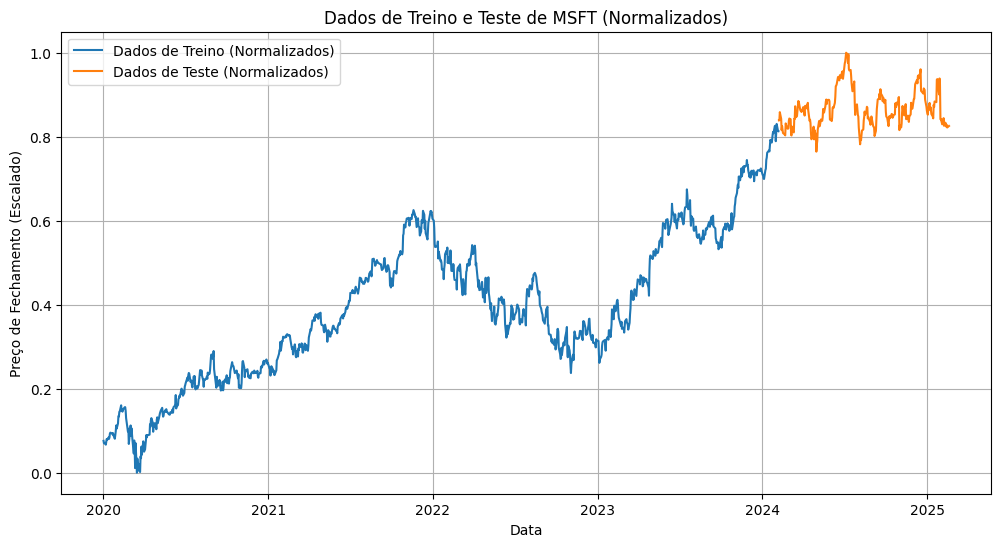

In [22]:
plot_training_and_test_data(train_data, test_data, symbol)

Utilizando a variação em % para analise na utilização do LSTM

In [23]:
df_diff = df[['Close']].diff().dropna()
df_diff.index = pd.to_datetime(df_diff.index)

In [24]:
df_diff.head()

,Close
date,
2020-01-03,-2.00
2020-01-06,0.41
2020-01-07,-1.45
2020-01-08,2.51
2020-01-09,2.00


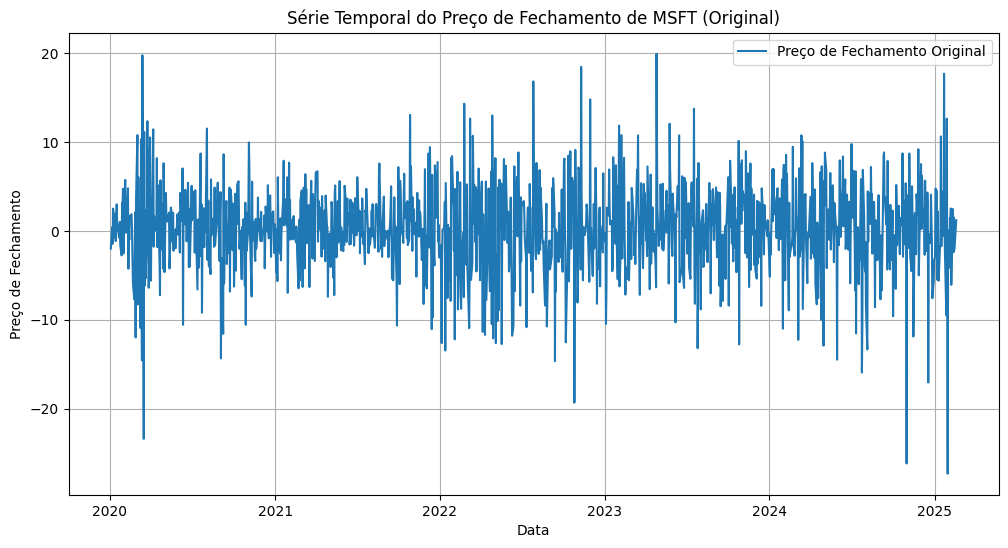

In [25]:
plot_closing_price_time_series(df_diff, symbol)

#### Pré-processamento

In [26]:
scaler = MinMaxScaler()
scaled_data_diff = scaler.fit_transform(df_diff.values)

In [27]:
df_scaled_diff = pd.DataFrame(scaled_data_diff, columns=df_diff.columns, index=df_diff.index)

In [28]:
df_scaled_diff.head()

,Close
date,
2020-01-03,0.535843
2020-01-06,0.586805
2020-01-07,0.547473
2020-01-08,0.631212
2020-01-09,0.620427


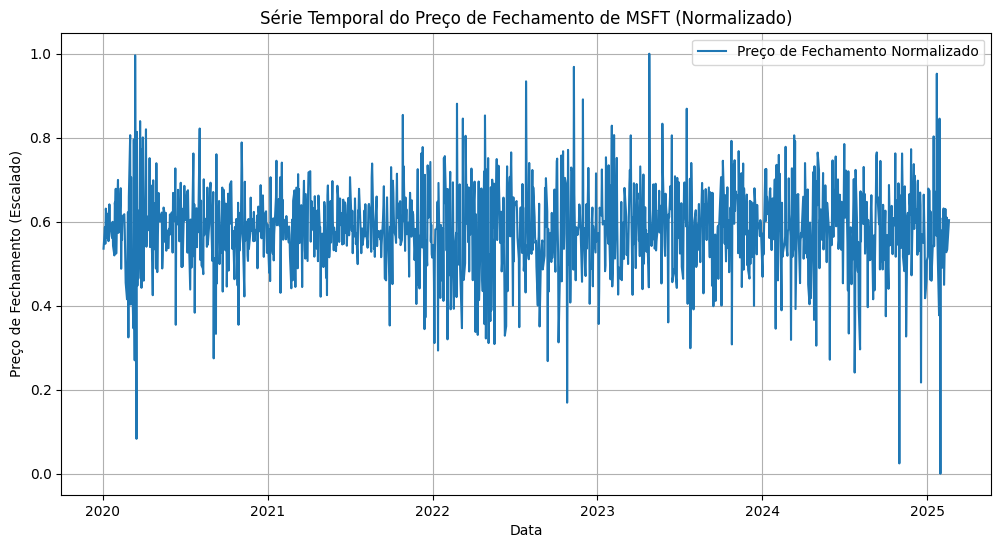

In [29]:
plot_normalized_closing_price_time_series(df_scaled_diff, symbol)

#### Data Splitting (Treino e Teste)

In [30]:
train_size = int(len(df) * 0.8)
train_data_diff = df_scaled_diff[:train_size]
test_data_diff = df_scaled_diff[train_size:]

In [31]:
print(f"Tamanho dos dados de treino: {len(train_data_diff)}")
print(f"Tamanho dos dados de teste: {len(test_data_diff)}")

Tamanho dos dados de treino: 1031
Tamanho dos dados de teste: 257


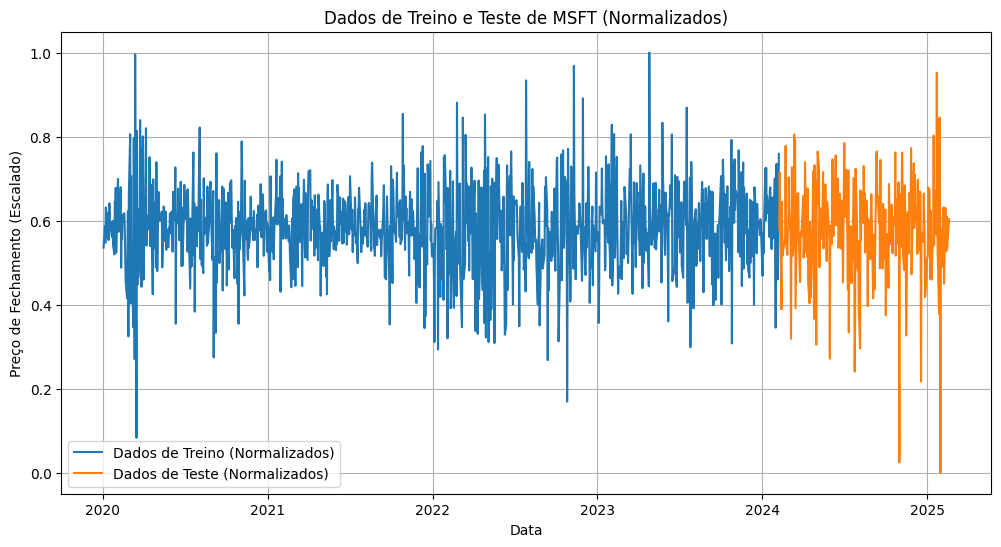

In [32]:
plot_training_and_test_data(train_data_diff, test_data_diff, symbol)

#### Construindo o modelo utilizando os preços.

Preparando para LSTM

In [33]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [34]:
time_steps = 60
X_train, y_train = create_sequences(train_data.values, time_steps)
X_test, y_test = create_sequences(test_data.values, time_steps)

In [35]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [36]:
print("Formato X_train:", X_train.shape)
print("Formato y_train:", y_train.shape)
print("Formato X_test:", X_test.shape)
print("Formato y_test:", y_test.shape)

Formato X_train: (971, 60, 1)
Formato y_train: (971,)
Formato X_test: (198, 60, 1)
Formato y_test: (198,)


#### Criando o modelo LSTM

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [39]:
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=10, 
                                restore_best_weights=True)

In [40]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', rmse])

model.summary()

c:\Users\ernan\anaconda3\envs\venv-tech\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0788 - mae: 0.2171 - mse: 0.0788 - rmse: 0.2967 - val_loss: 0.0070 - val_mae: 0.0755 - val_mse: 0.0070 - val_rmse: 0.0784
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0051 - mae: 0.0582 - mse: 0.0051 - rmse: 0.2009 - val_loss: 0.0067 - val_mae: 0.0739 - val_mse: 0.0067 - val_rmse: 0.0777
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0029 - mae: 0.0408 - mse: 0.0029 - rmse: 0.2178 - val_loss: 0.0015 - val_mae: 0.0327 - val_mse: 0.0015 - val_rmse: 0.0430
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025 - mae: 0.0385 - mse: 0.0025 - rmse: 0.2159 - val_loss: 0.0021 - val_mae: 0.0363 - val_mse: 0.0021 - val_rmse: 0.0501
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0026 - mae: 0.0386 - mse: 0.0026 - rmse: 0.2245 - val_loss: 0.0019 - val_mae: 0.0365 - val_mse: 0.0019 - val_rmse: 0.0434
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025 - mae: 0.0371

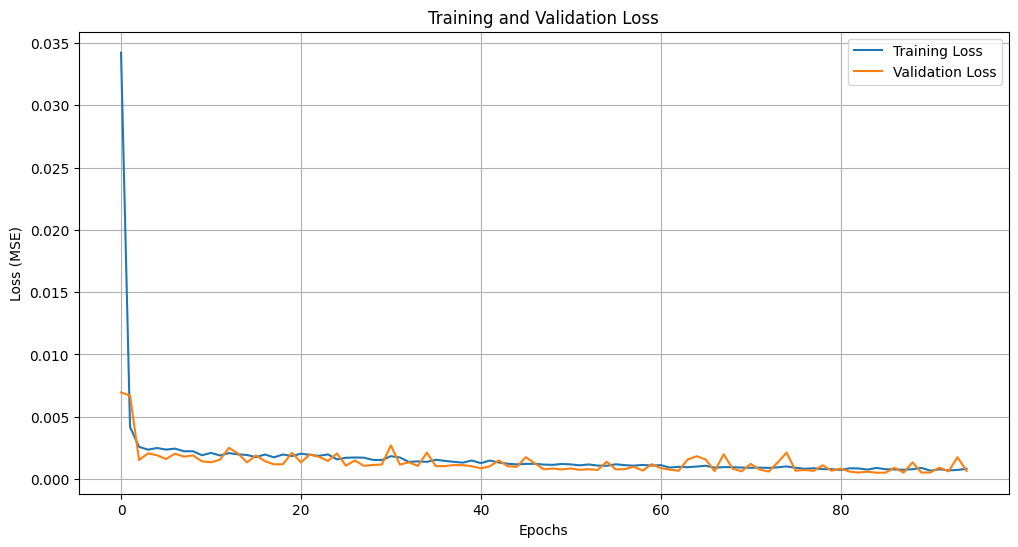

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

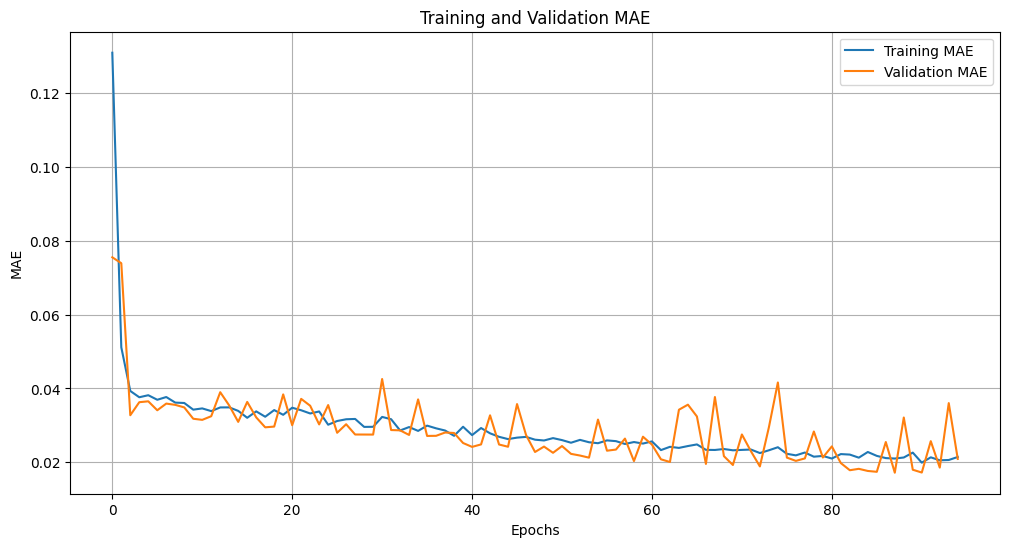

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

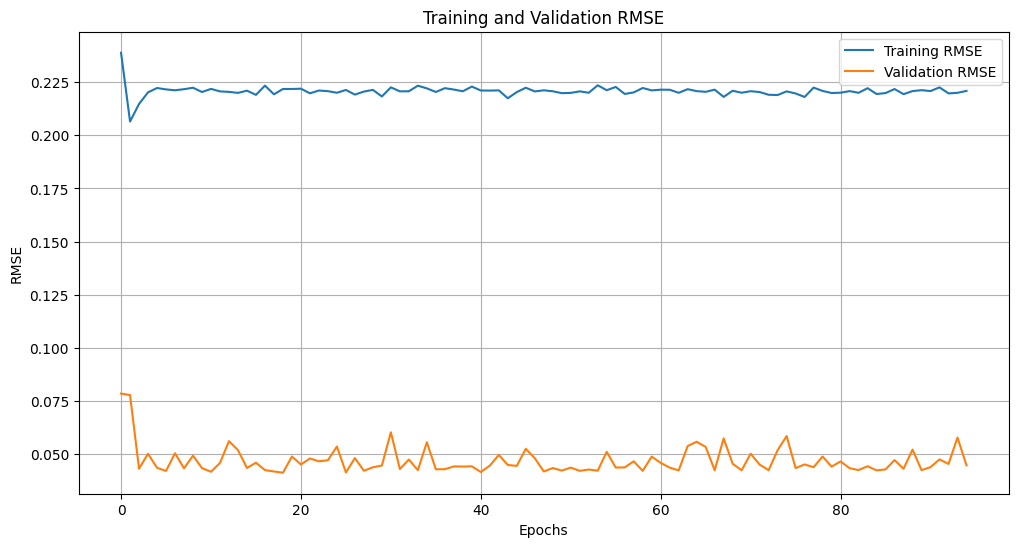

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['rmse'], label='Training RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

#### Avaliando o modelo com o conjunto de Test

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [46]:
test_loss, test_mae, test_mse, test_rmse = model.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9887e-04 - mae: 0.0178 - mse: 4.9887e-04 - rmse: 0.0483 


In [47]:
predicted_scaled = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_scaled)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [48]:
test_dates = test_data.index
start_date_test = test_dates[0]
end_date_test = test_dates[-1]
real_prices_df = yf.download(symbol, start=start_date_test, end=end_date_test, multi_level_index=False)
real_prices_df = real_prices_df[['Close']]
real_prices_df.index = pd.to_datetime(real_prices_df.index)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [55]:
real_prices_df = df

In [56]:
real_prices_df

,Close
date,
2020-01-02,160.62
2020-01-03,158.62
2020-01-06,159.03
2020-01-07,157.58
2020-01-08,160.09
...,...
2025-02-11,411.44
2025-02-12,409.04
2025-02-13,410.54


In [49]:
print(start_date_test, end_date_test)

2024-02-07 00:00:00 2025-02-18 00:00:00


In [57]:
real_prices_df.dropna(inplace=True)

In [58]:
real_prices = real_prices_df['Close'].values

In [59]:
real_prices_cortado = real_prices[-len(predicted_prices):]

In [62]:
predicted_prices

array([[ 9.907399 ],
       [10.136813 ],
       [10.768566 ],
       [11.323392 ],
       [11.7572775],
       [12.078445 ],
       [12.336261 ],
       [12.45282  ],
       [12.559093 ],
       [12.84834  ],
       [13.080864 ],
       [13.204771 ],
       [13.418734 ],
       [13.747989 ],
       [14.106703 ],
       [14.270921 ],
       [14.409319 ],
       [14.498193 ],
       [14.4982605],
       [13.948018 ],
       [13.282939 ],
       [12.6557865],
       [12.288918 ],
       [12.420205 ],
       [12.802788 ],
       [13.219017 ],
       [13.703002 ],
       [14.271036 ],
       [15.034704 ],
       [15.720413 ],
       [16.228659 ],
       [16.716675 ],
       [16.980171 ],
       [17.032824 ],
       [17.100988 ],
       [17.070448 ],
       [17.11676  ],
       [17.230024 ],
       [17.377352 ],
       [17.296162 ],
       [17.483425 ],
       [17.841705 ],
       [18.258633 ],
       [18.855385 ],
       [19.339031 ],
       [19.397314 ],
       [19.474398 ],
       [19.09

In [61]:
real_prices_cortado

array([406.66, 413.54, 409.34, 410.54, 412.32, 414.74, 413.72, 416.56,
       423.08, 420.99, 420.21, 425.34, 429.04, 430.52, 427.  , 430.16,
       430.32, 429.17, 414.67, 415.13, 413.52, 416.07, 424.01, 424.52,
       423.85, 427.87, 432.68, 441.06, 441.58, 442.57, 448.37, 446.34,
       445.7 , 449.78, 447.67, 450.95, 452.16, 452.85, 446.95, 456.73,
       459.28, 460.77, 467.56, 466.24, 459.54, 466.25, 454.7 , 453.55,
       453.96, 449.52, 443.52, 440.37, 437.11, 442.94, 444.85, 428.9 ,
       418.4 , 425.27, 426.73, 422.92, 418.35, 417.11, 408.49, 395.15,
       399.61, 398.43, 402.69, 406.02, 406.81, 414.01, 416.86, 421.03,
       418.47, 421.53, 424.8 , 424.14, 415.55, 416.79, 413.49, 413.84,
       410.6 , 413.12, 417.14, 409.44, 408.9 , 408.39, 401.7 , 405.72,
       414.2 , 423.04, 427.  , 430.59, 431.34, 435.15, 430.81, 438.69,
       435.27, 433.51, 429.17, 432.11, 431.31, 428.02, 430.3 , 420.69,
       417.13, 416.54, 416.06, 409.54, 414.71, 417.46, 415.84, 416.32,
      

In [63]:
test_mae_unscaled = mean_absolute_error(real_prices_cortado, predicted_prices)
test_rmse_unscaled = np.sqrt(mean_squared_error(real_prices_cortado, predicted_prices))

In [64]:
print(f"Comprimento de predicted_prices: {len(predicted_prices)}")
print(f"Comprimento de real_prices (antes de cortar): {len(real_prices)}")
print(f"Comprimento de real_prices_cortado: {len(real_prices_cortado)}")
print(f"Comprimento de y_test: {len(y_test)}")
print(f"Comprimento de X_test: {len(X_test)}")

Comprimento de predicted_prices: 198
Comprimento de real_prices (antes de cortar): 1289
Comprimento de real_prices_cortado: 198
Comprimento de y_test: 198
Comprimento de X_test: 198


In [65]:
print("--- Resultados da Avaliação no Conjunto de Teste ---")
print(f"Test Loss (MSE): {test_loss:.4f}") # Note: Loss is still calculated on the *original* test set (with NaNs in real_prices potentially)
print(f"Test MAE: {test_mae:.4f}")       # Note: MAE is still calculated on the *original* test set (with NaNs in real_prices potentially)
print(f"Test MSE: {test_mse:.4f}")       # Note: MSE is still calculated on the *original* test set (with NaNs in real_prices potentially)
print(f"Test RMSE: {test_rmse:.4f}")      # Note: RMSE is still calculated on the *original* test set (with NaNs in real_prices potentially)

--- Resultados da Avaliação no Conjunto de Teste ---
Test Loss (MSE): 0.0005
Test MAE: 0.0176
Test MSE: 0.0005
Test RMSE: 0.0422


In [66]:
print("\n--- Métricas Desnormalizadas (na escala de Preço) ---")
print(f"Test MAE (Preço Original): ${test_mae_unscaled:.2f}")
print(f"Test RMSE (Preço Original): ${test_rmse_unscaled:.2f}")


--- Métricas Desnormalizadas (na escala de Preço) ---
Test MAE (Preço Original): $412.41
Test RMSE (Preço Original): $412.62


#### Salvando o modelo

In [67]:
model.save('lstm_model.keras')